In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
batch_size=32

In [4]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)

scaler = MinMaxScaler()
data_output_scaled = scaler.fit_transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=10000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :3].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 3:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :3].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 3:].values, dtype=torch.float32)

In [5]:
train_inputs.shape[0]

8000

In [6]:
torch.manual_seed(1)

In [7]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([8000, 255])

In [8]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [9]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [10]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=252, condition_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # No Sigmoid — output is a raw score
        )

    def forward(self, x, conditions):
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [11]:
discriminator = ConditionalDiscriminator()

In [12]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=3, output_dim=252):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z, conditions):
        # Concatenate noise and condition
        x = torch.cat([z, conditions], dim=1)
        return self.model(x)

generator = ConditionalGenerator()

In [13]:
lr = 0.001
num_epochs = 300

In [14]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))

In [23]:
lambda_gp = 10  # Gradient penalty coefficient
latent_dim = 100
for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        real_samples = real_samples.to('cpu')
        condition_vectors = condition_vectors.to('cpu')
        batch_size = real_samples.size(0)

        # === Train Critic multiple times (e.g., 5 steps per 1 generator step) ===
        for _ in range(5):
            z = torch.randn((batch_size, latent_dim), device='cpu')
            fake_samples = generator(z, condition_vectors).detach()

            # Critic scores
            critic_real = discriminator(real_samples, condition_vectors)
            critic_fake = discriminator(fake_samples, condition_vectors)

            # Gradient penalty
            alpha = torch.rand(batch_size, 1, device='cpu')
            alpha = alpha.expand_as(real_samples)
            interpolated = alpha * real_samples + (1 - alpha) * fake_samples
            interpolated.requires_grad_(True)

            critic_interpolated = discriminator(interpolated, condition_vectors)

            gradients = torch.autograd.grad(
                outputs=critic_interpolated,
                inputs=interpolated,
                grad_outputs=torch.ones_like(critic_interpolated),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            gradients = gradients.view(batch_size, -1)
            gradient_norm = gradients.norm(2, dim=1)
            gp = lambda_gp * ((gradient_norm - 1) ** 2).mean()

            # Critic loss
            loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake) + gp

            optimizer_discriminator.zero_grad()
            loss_critic.backward()
            optimizer_discriminator.step()

        # === Train Generator ===
        z = torch.randn((batch_size, latent_dim), device='cpu')
        generated_samples = generator(z, condition_vectors)
        critic_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = -torch.mean(critic_generated)

        optimizer_generator.zero_grad()
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging ===
        if n % 100 == 0 and epoch % 25 == 0:
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_critic.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 7.059412002563477
Epoch: 0 Step: 0 Loss G.: 0.05328875780105591
Epoch: 0 Step: 100 Loss D.: -1.3459317684173584
Epoch: 0 Step: 100 Loss G.: 0.6865763664245605
Epoch: 0 Step: 200 Loss D.: -1.6162285804748535
Epoch: 0 Step: 200 Loss G.: -1.4368313550949097
Epoch: 25 Step: 0 Loss D.: -0.5287626385688782
Epoch: 25 Step: 0 Loss G.: 4.59103536605835
Epoch: 25 Step: 100 Loss D.: -1.5281164646148682
Epoch: 25 Step: 100 Loss G.: 2.4986438751220703
Epoch: 25 Step: 200 Loss D.: -1.7465534210205078
Epoch: 25 Step: 200 Loss G.: 2.9585676193237305
Epoch: 50 Step: 0 Loss D.: -0.6586582064628601
Epoch: 50 Step: 0 Loss G.: 1.986603856086731
Epoch: 50 Step: 100 Loss D.: -1.1467819213867188
Epoch: 50 Step: 100 Loss G.: 1.276863694190979
Epoch: 50 Step: 200 Loss D.: -0.26756995916366577
Epoch: 50 Step: 200 Loss G.: 4.240024566650391
Epoch: 75 Step: 0 Loss D.: -0.4580363631248474
Epoch: 75 Step: 0 Loss G.: 0.24618983268737793
Epoch: 75 Step: 100 Loss D.: -0.585576057434082
Epoch: 

In [41]:
import random

# Pick N random examples from your validation set
n_samples = 20
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [42]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

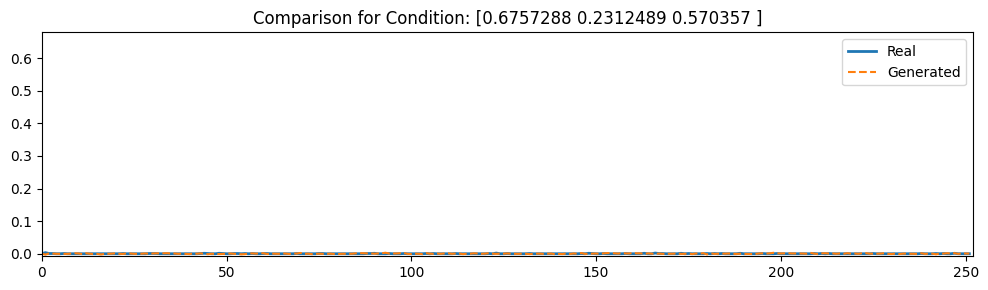

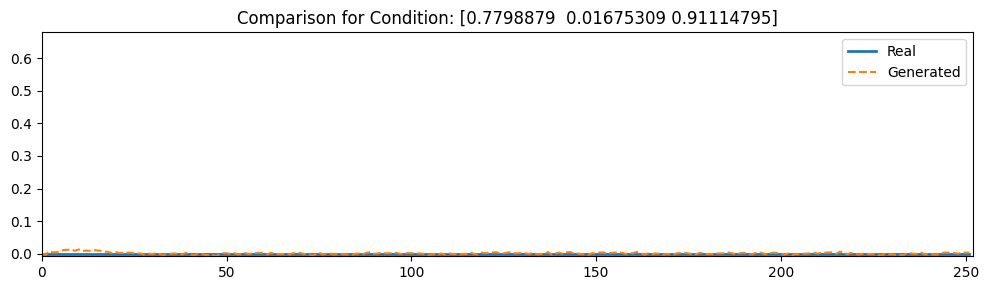

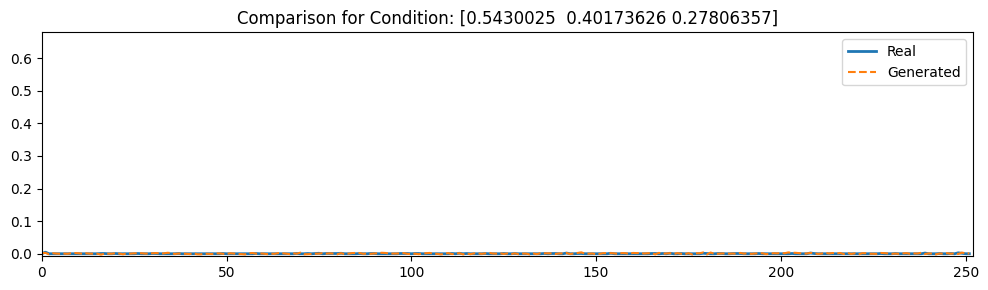

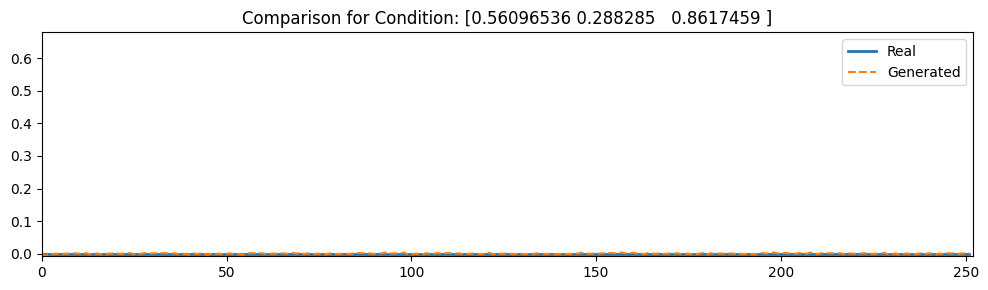

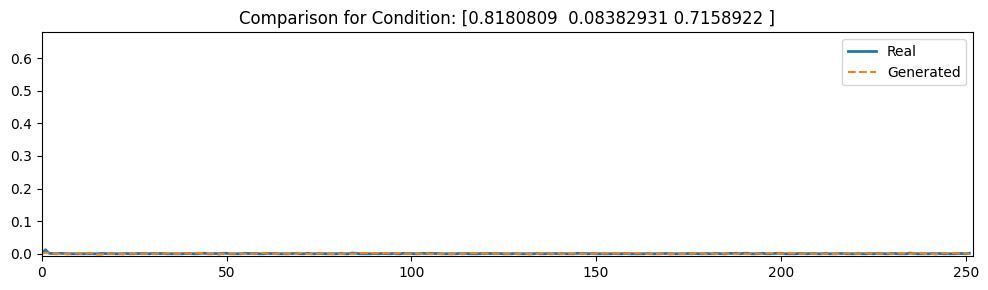

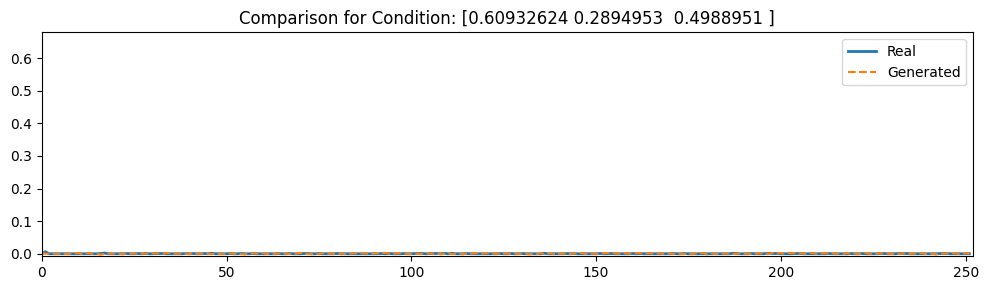

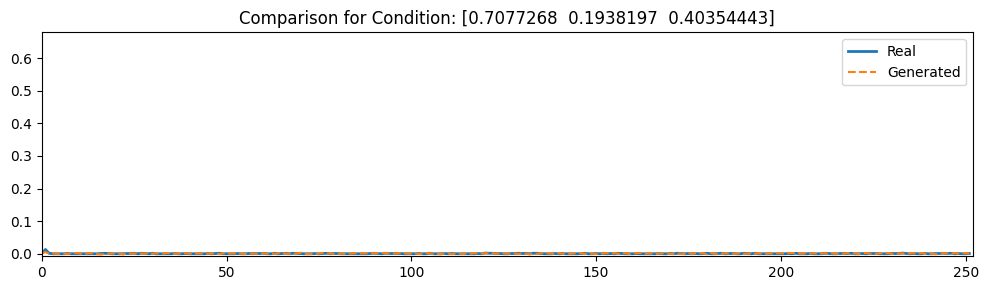

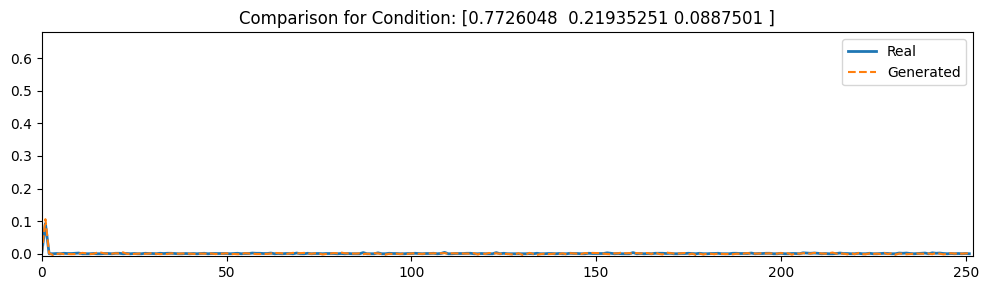

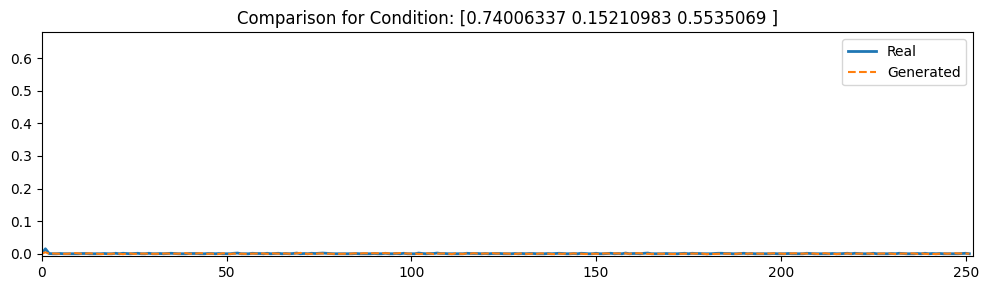

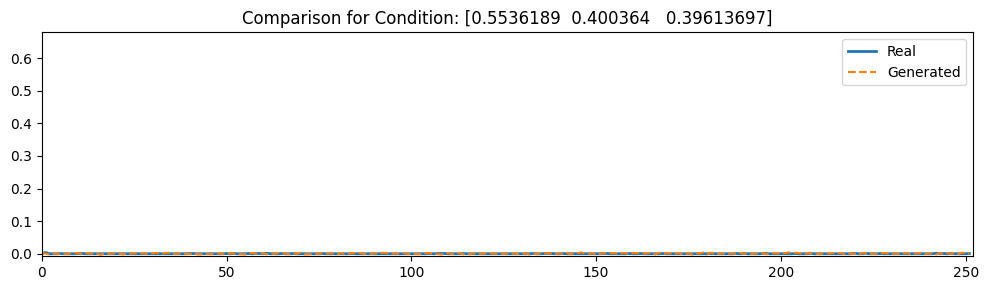

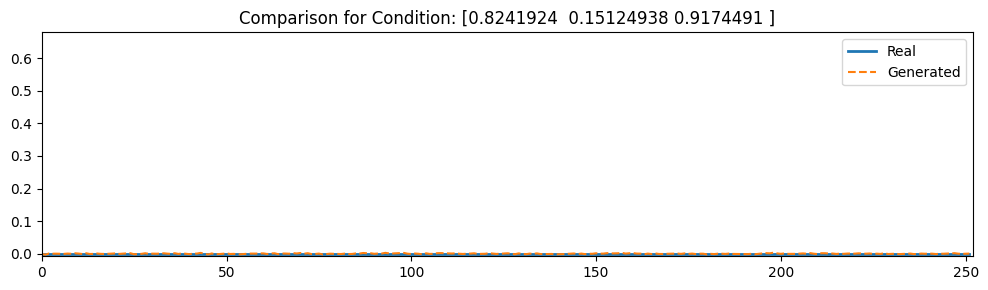

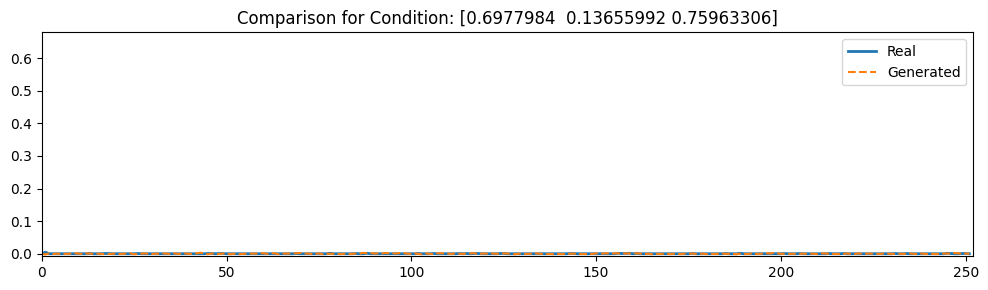

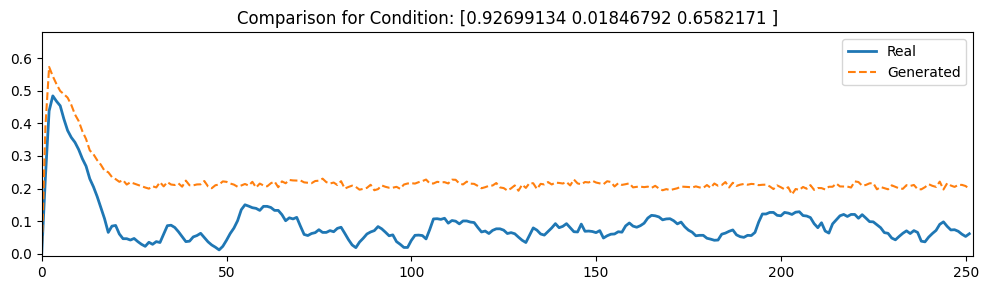

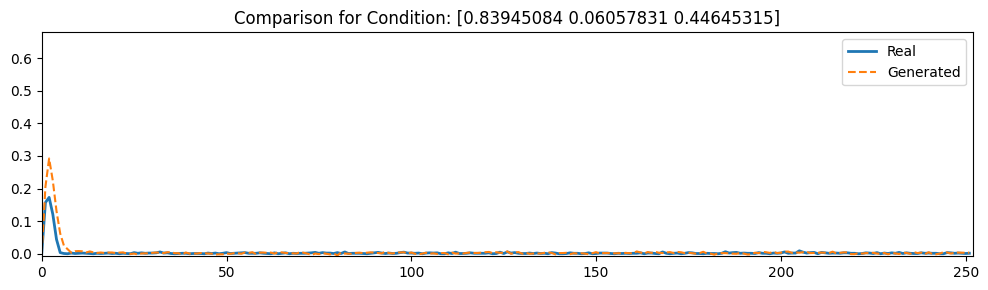

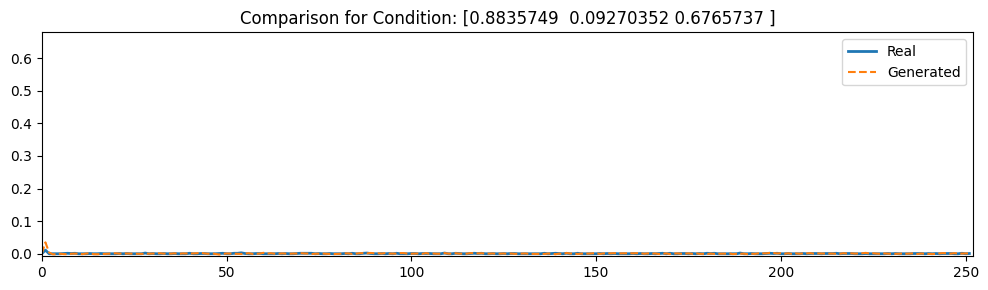

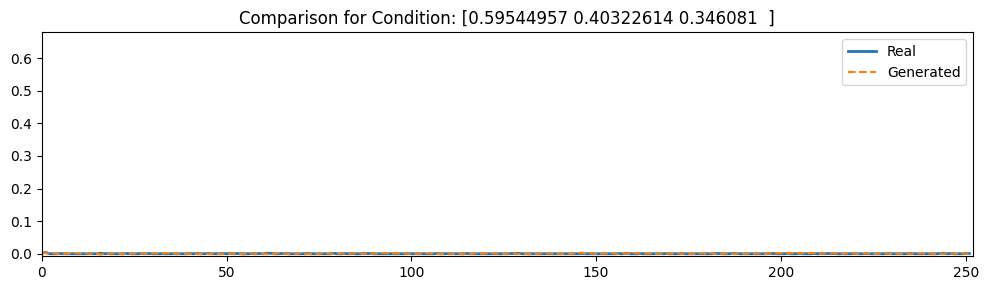

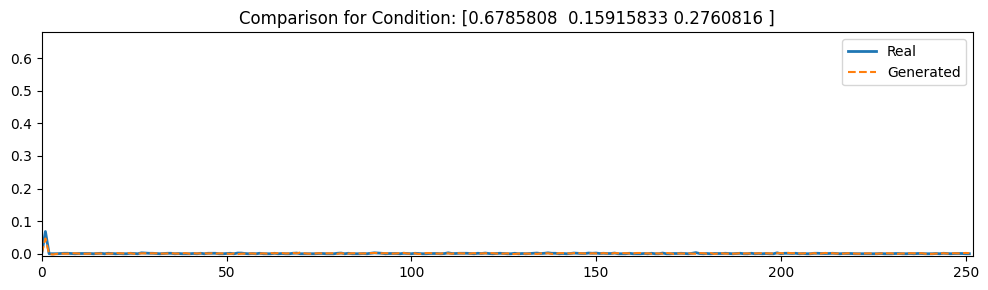

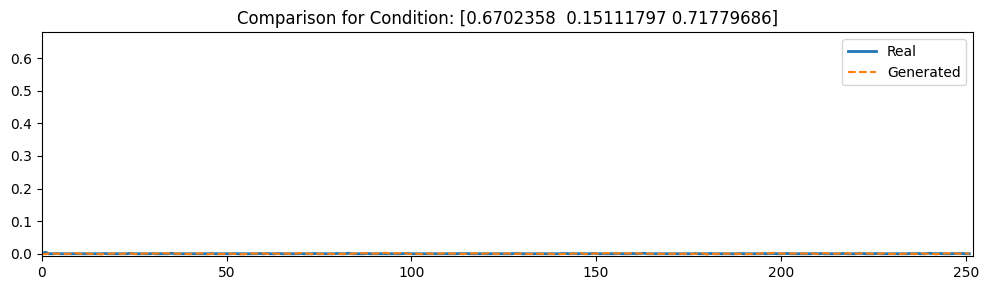

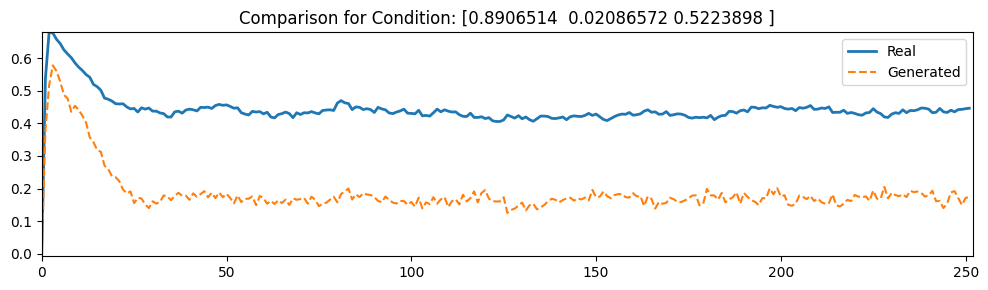

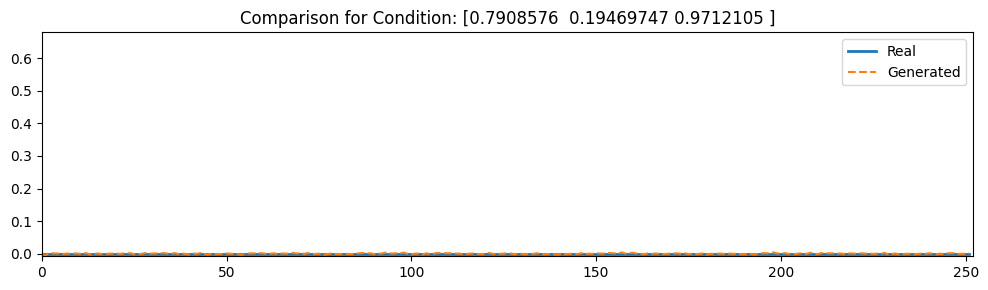

In [43]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(n_samples):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [39]:
def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.004431
Validation MAE: 0.026772
Validation R² Score: 0.911481


(0.004431427922099829, 0.026771562173962593, 0.9114813804626465)